# Linear SVM to Detect Distracted Driver

In [40]:
import numpy as np 
import tensorflow as tf 
import matplotlib.pyplot as plt 
import pathlib
from src.data.dataset_loader import load_distracted_driver_detection_list, load_dataset_image_label
from src.data.image_label_loader import ImageLabelLoader
from src.evaluation import metrics
from src.utils.data_util import get_paths, sample_dataset
from src.preprocessing.batch import tf_flatten, bias_trick
from src.preprocessing.standardizer import Standardizer
from src.visualization.history_plotter import plot_loss_acc_history_epoch
from src.visualization.weights_visualization import visualize_weights
from src.classifiers.linear_svm import LinearSVM
from src.solver.solver import Solver

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
data_dir = pathlib.Path("dataset/raw/imgs/train") # Train directory

X_train_filenames, X_val_filenames, y_train_labels, y_val_labels = load_distracted_driver_detection_list(val_size=0.2, split_on_driver=True, random_state=12)
train_paths = get_paths(data_dir, X_train_filenames, y_train_labels)
val_paths = get_paths(data_dir, X_val_filenames, y_val_labels)
class_names = np.array(sorted([item.name for item in data_dir.glob('*')]))

num_train = len(train_paths)
num_val = len(val_paths)
num_classes = len(class_names)

print(f'Training set size: {num_train}')
print(f'Validation set size: {num_val}')
print(f'Number of classes: {num_classes}')

Training set size: 17761
Validation set size: 4663
Number of classes: 10


In [10]:
rng = tf.random.Generator.from_seed(123, alg='philox')

def wrap_augment(image, label):
    seed = rng.make_seeds(2)[0]
    image = augment(image, seed)
    return image, label

def augment(image, seed):
    image = tf.image.stateless_random_brightness(image, max_delta=0.5, seed=seed)
    image = tf.image.stateless_random_hue(image, max_delta=0.5, seed=seed)
    image = tf.image.stateless_random_contrast(image, lower=0.9, upper=1.2, seed=seed)
    image = tf.image.stateless_random_saturation(image, lower=1, upper=1.2, seed=seed)
    image = tf.image.stateless_random_jpeg_quality(image, min_jpeg_quality=50, max_jpeg_quality=100, seed=seed)
    #image = tf.image.stateless_random_crop(image, size=(60,60,3), seed=seed)
    #image = tf.image.stateless_random_flip_left_right(image, seed)
    #image = tf.image.stateless_random_flip_up_down(image, seed)
    return image

def preprocess(X_batch, y_batch):
    X_batch = standardizer.transform(X_batch) # Standardize
    X_batch = tf_flatten(X_batch) # Flatten image to row
    X_batch = bias_trick(X_batch) # Add 1 for bias included in W
    return X_batch, y_batch

In [11]:
# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del train_dset
   del val_dset
   print('Clear previously loaded data.')
except:
   pass

CPU = '/cpu:0'
GPU = '/device:GPU:0'

BATCH_SIZE = 32
IMG_SHAPE = (64, 64, 3)
loader = ImageLabelLoader(class_names, img_shape=IMG_SHAPE)
standardizer = Standardizer()

# Force image load and preprocessing with specific device
with tf.device(CPU):
    # Train dataset input pipeline
    train_dset = tf.data.Dataset.from_tensor_slices(train_paths)
    train_dset = train_dset.map(loader.load, num_parallel_calls=tf.data.experimental.AUTOTUNE) # Load from path to image, label
    #train_dset = train_dset.map(wrap_augment, num_parallel_calls=tf.data.experimental.AUTOTUNE) # Image Augmentation
    train_dset = train_dset.cache()
    train_dset = train_dset.shuffle(buffer_size=num_train, reshuffle_each_iteration=True)
    train_dset = train_dset.batch(BATCH_SIZE, drop_remainder=False)
    standardizer.fit(train_dset) # Fit mean and std to train set
    train_dset = train_dset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    train_dset = train_dset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    # Validation dataset input pipeline
    val_dset = tf.data.Dataset.from_tensor_slices(val_paths)
    val_dset = val_dset.map(loader.load, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dset = val_dset.batch(BATCH_SIZE, drop_remainder=False)
    val_dset = val_dset.map(preprocess, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    val_dset = val_dset.cache()
    val_dset = val_dset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)


Clear previously loaded data.


In [ ]:
BIAS = 1
INPUT_DIM = IMG_SHAPE[0] * IMG_SHAPE[1] * IMG_SHAPE[2] + BIAS

learning_rates = [1e-5, 1e-1, 1e-8]
lr_decays = [0.90, 0.95, 0.8, 0.7]
weight_scales = [1e-5, 1e-1, 1e-3]
reg_strengths = [0.25, 0.1, 0.5, 2.5]

best_val =-1
best_solver = None

# permute over hyperparameters
grid_search = [(learning_rate, lr_decay, weight_scale, reg_strength) \
                for learning_rate in learning_rates \
                for lr_decay in lr_decays \
                for weight_scale in weight_scales \
                for reg_strength in reg_strengths \
                ]

for learning_rate, lr_decay, weight_scale, reg_strength in grid_search:
    model = LinearSVM(INPUT_DIM, num_classes, weight_scale=weight_scale, reg=reg_strength)
    solver = Solver(model, train_dset, val_dset,
                    update_rule='sgd',
                    optim_config={
                        'learning_rate': learning_rate
                    },
                    lr_decay=lr_decay,
                    num_epochs=5,
                    verbose=False)

    solver.train()

    train_loss, train_acc = solver.evaluate(train_dset)
    val_loss, val_acc = solver.evaluate(val_dset)
    if val_acc >= best_val:
        best_val = val_acc
        best_solver = solver

    print('(learning_rate %e - lr_decay %e - weight_scale %e - reg_strength %e - train_acc %f -  val_acc %f)' % (learning_rate, lr_decay, weight_scale, reg_strength, train_acc, val_acc))
    print("===============================================")

In [12]:
BIAS = 1
INPUT_DIM = IMG_SHAPE[0] * IMG_SHAPE[1] * IMG_SHAPE[2] + BIAS

model = LinearSVM(INPUT_DIM, num_classes, weight_scale=1e-3, reg=0.25)
solver = Solver(model, train_dset, val_dset,
                update_rule='sgd',
                optim_config={
                    'learning_rate': 1e-4
                },
                lr_decay=0.95,
                num_epochs=10,
                verbose=True)

solver.train()

Epoch 1/10
556/556 - loss: 3.4955 - accuracy: 0.5804 - val_loss: 0.1205 - val_accuracy: 0.6871
Epoch 2/10
556/556 - loss: 1.4509 - accuracy: 0.8250 - val_loss: 0.1359 - val_accuracy: 0.6305
Epoch 3/10
556/556 - loss: 1.1378 - accuracy: 0.8716 - val_loss: 0.1624 - val_accuracy: 0.7201
Epoch 4/10
556/556 - loss: 0.9268 - accuracy: 0.9073 - val_loss: 0.1777 - val_accuracy: 0.6715
Epoch 5/10
556/556 - loss: 0.8463 - accuracy: 0.9222 - val_loss: 0.1995 - val_accuracy: 0.7053
Epoch 6/10
556/556 - loss: 0.7625 - accuracy: 0.9372 - val_loss: 0.2178 - val_accuracy: 0.7079
Epoch 7/10
556/556 - loss: 0.7249 - accuracy: 0.9444 - val_loss: 0.2208 - val_accuracy: 0.7073
Epoch 8/10
556/556 - loss: 0.6913 - accuracy: 0.9517 - val_loss: 0.2235 - val_accuracy: 0.6987
Epoch 9/10
556/556 - loss: 0.6648 - accuracy: 0.9539 - val_loss: 0.2279 - val_accuracy: 0.7094
Epoch 10/10
556/556 - loss: 0.6466 - accuracy: 0.9592 - val_loss: 0.2366 - val_accuracy: 0.7109


In [ ]:
plot_loss_acc_history_epoch(solver.loss_history, solver.val_loss_history, solver.accuracy_history, solver.val_accuracy_history)

Log Loss: 1.2836144857430427
Val Accuracy: 0.7201372506969762
Confusion Matrix:
[[338.  13.  16.   3.  54.  21.   2.   1.   5.  10.]
 [  0. 386.  26.   1.   0.   1.  37.   5.  13.   1.]
 [  4.   9. 339.   0.  21.  15.  42.   7.  62.   0.]
 [  9.   0.  34. 324. 110.   6.   0.   0.   0.   7.]
 [ 59.  29.   1.   5. 338.   9.   8.   0.   9.  38.]
 [  1.   0.  15.   0.  10. 455.  13.   1.   9.   1.]
 [  1.  42.  13.   3.   2.   0. 365.   4.  38.  15.]
 [  0.   2.   7.   2.   0.   4.   4. 361.  19.   1.]
 [ 41.   5.   7.   1.   0.   2.  91.   4. 251.   2.]
 [ 32.  56. 126.   4.   8.   5.   2.   2.  17. 201.]]
Confusion Matrix Heatmap:


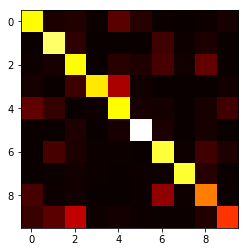

In [57]:
y_true = []
y_pred = []
y_scores = []
for _,(X_batch, y_batch) in enumerate(val_dset.as_numpy_iterator()):
    y_true.append(y_batch)

    scores = model.predict(X_batch)
    y_scores.append(scores)
    prediction = np.argmax(scores, axis=1)
    y_pred.append(prediction)
    
y_true = np.hstack(y_true)
y_pred = np.hstack(y_pred)
y_scores = np.concatenate(y_scores)

# Log Loss Score
log_loss = metrics.log_loss(y_true, y_scores)
print(f"Log Loss: {log_loss}")

# Validation Accuracy
val_acc = metrics.accuracy(y_true, y_pred)
print(f"Val Accuracy: {val_acc}")

# Confusion Matrix
conf_matrix = metrics.confusion_matrix(y_true, y_pred)
print('Confusion Matrix:')
print(conf_matrix)

# Heatmap of the confusion matrix
print("Confusion Matrix Heatmap:")
plt.imshow(conf_matrix, cmap='hot', interpolation='nearest')
plt.show()

c0: Safe Driving
c1: Texting - Right
c2: Talking on the phone - Right
c3: Texting - Left
c4: Talking on the phone - Left
c5: Operating The Radio
c6: Drinking
c7: Reaching Behind
c8: Hair and Makeup
c9: Talking to Passanger


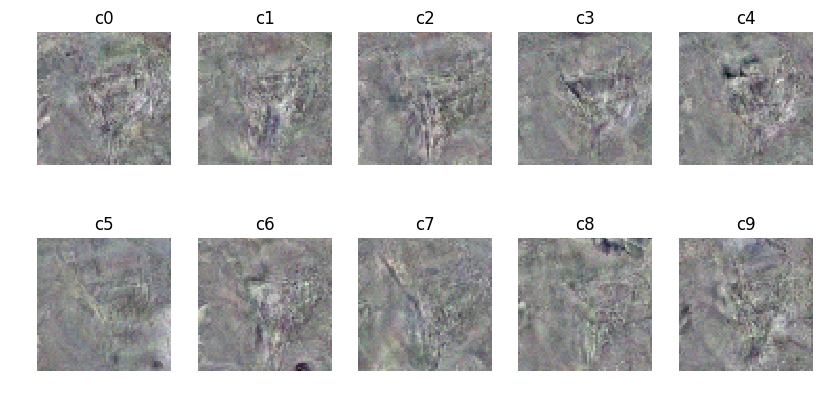

In [13]:
class_desc = ['Safe Driving', 'Texting - Right', 'Talking on the phone - Right', 
'Texting - Left', 'Talking on the phone - Left', 'Operating The Radio', 
'Drinking', 'Reaching Behind', 'Hair and Makeup', 'Talking to Passanger']
for class_name, class_desc in zip(class_names, class_desc):
    print(f'{class_name}: {class_desc}')

visualize_weights(model.params['W'], class_names, IMG_SHAPE, bias_in_weights=True)